# Ideal Parameter Analysis ($\delta=3$, $\tau=1.75$, $\alpha=2.25$) ($\delta$ upper bound, $\tau$ upper bound, $\alpha$ upper bound)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 3
expected_tau = 1.75
expected_alpha = 2.25

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

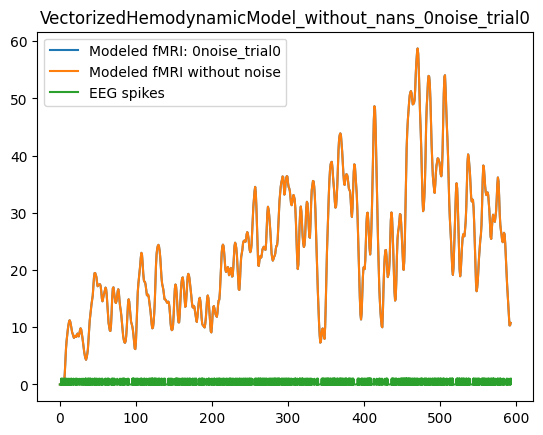

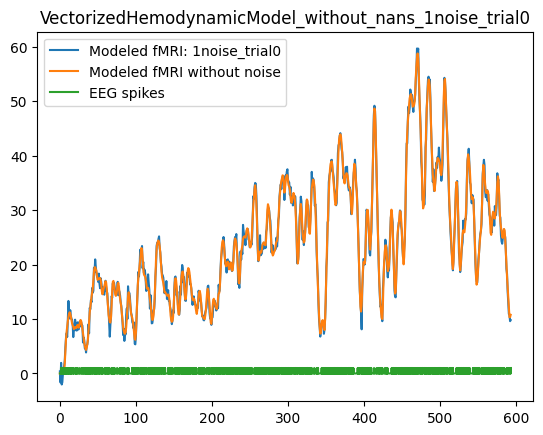

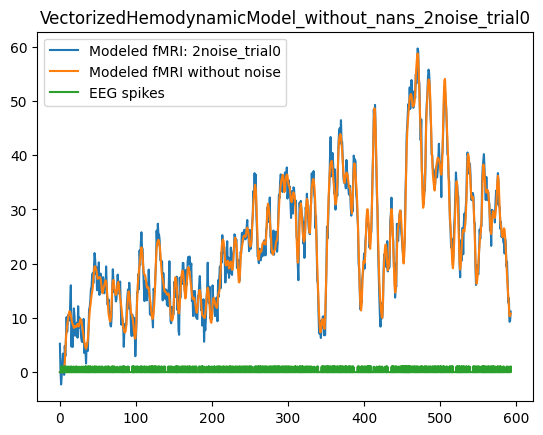

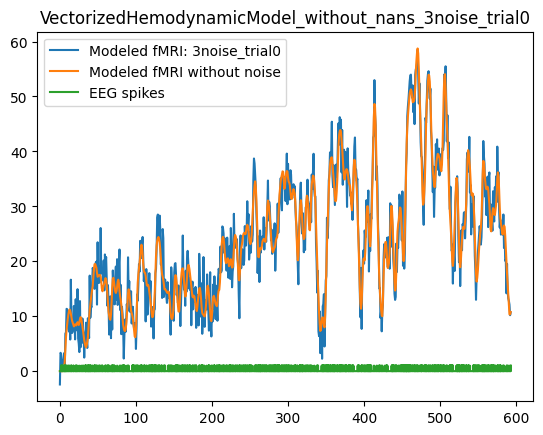

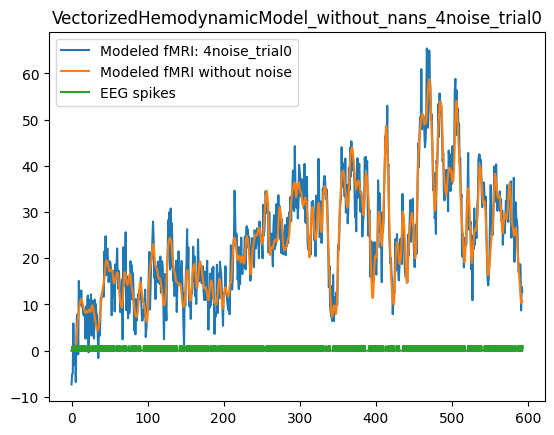

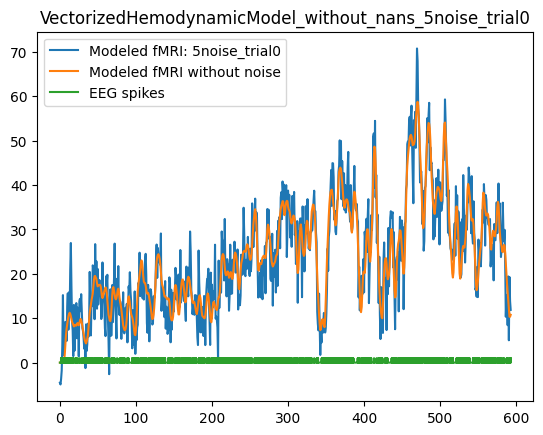

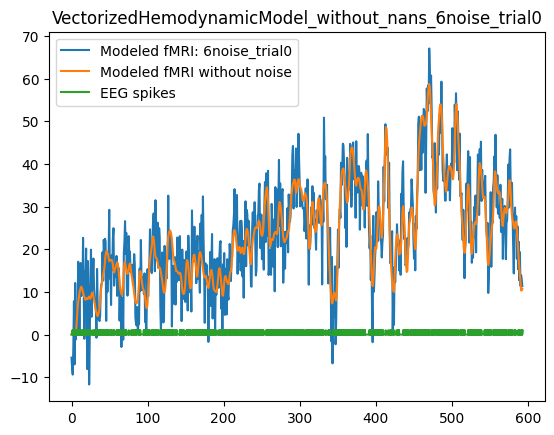

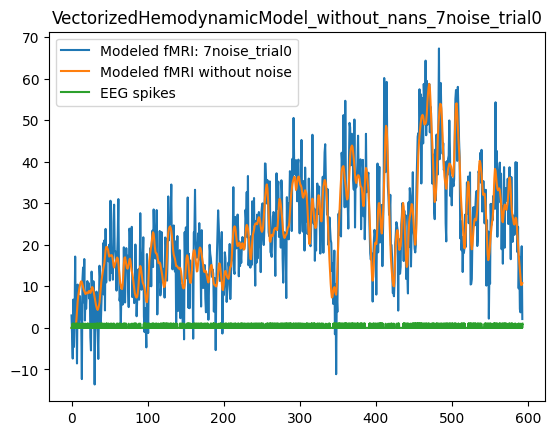

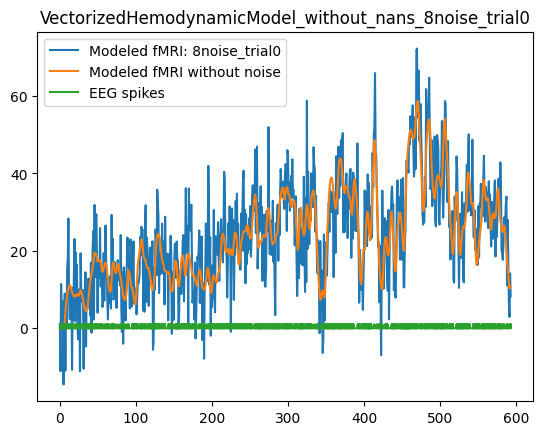

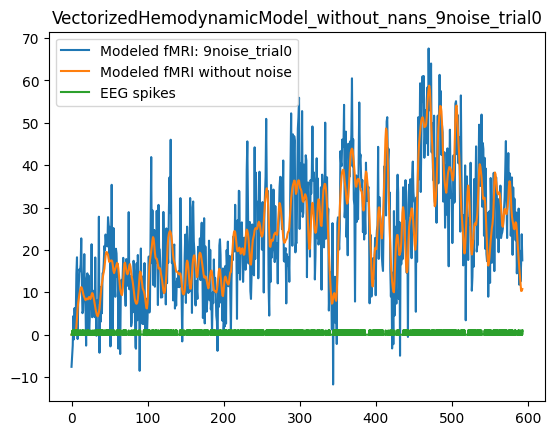

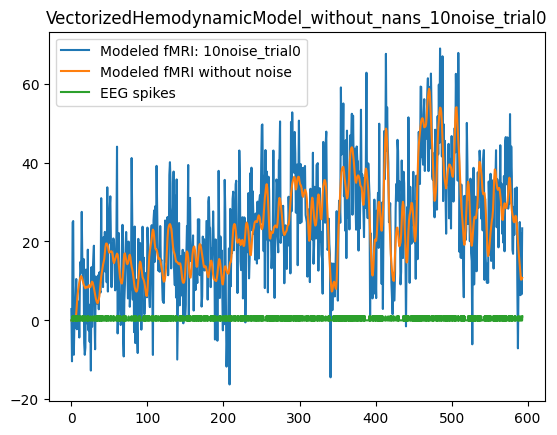

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 3, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.75, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2.25, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=3, tau=1.75, alpha=2.25


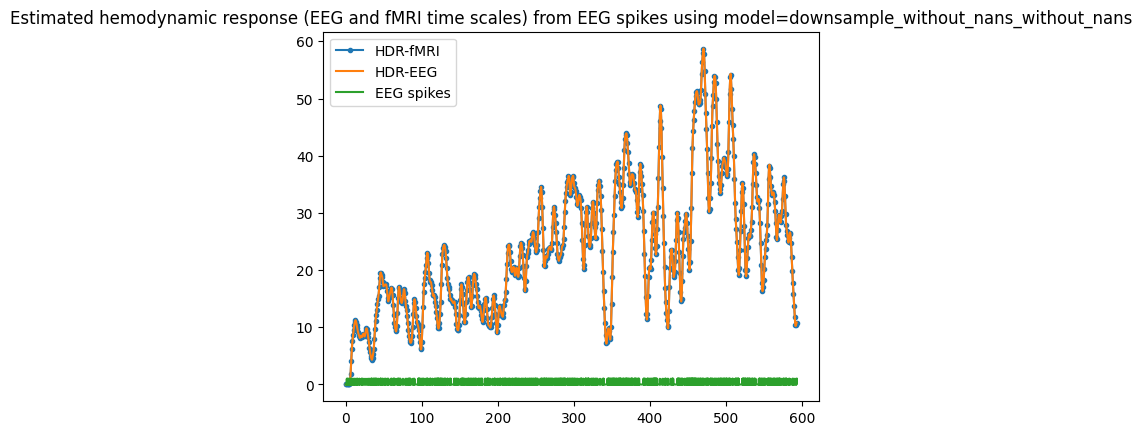

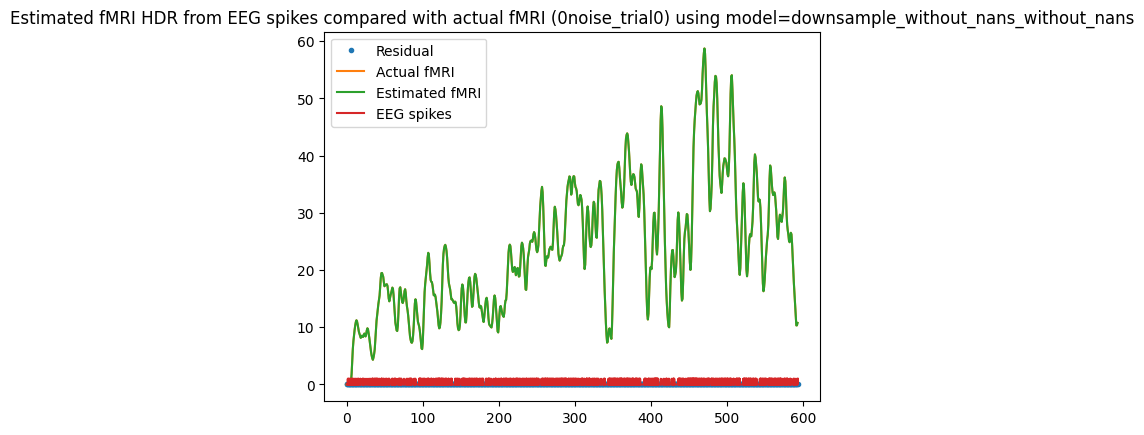

Residual Variance is 0.000000


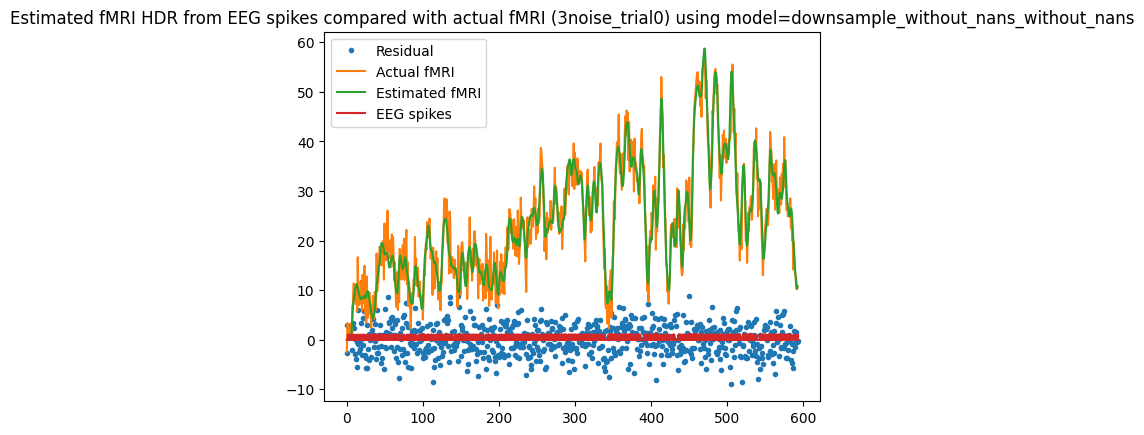

Residual Variance is 9.544414


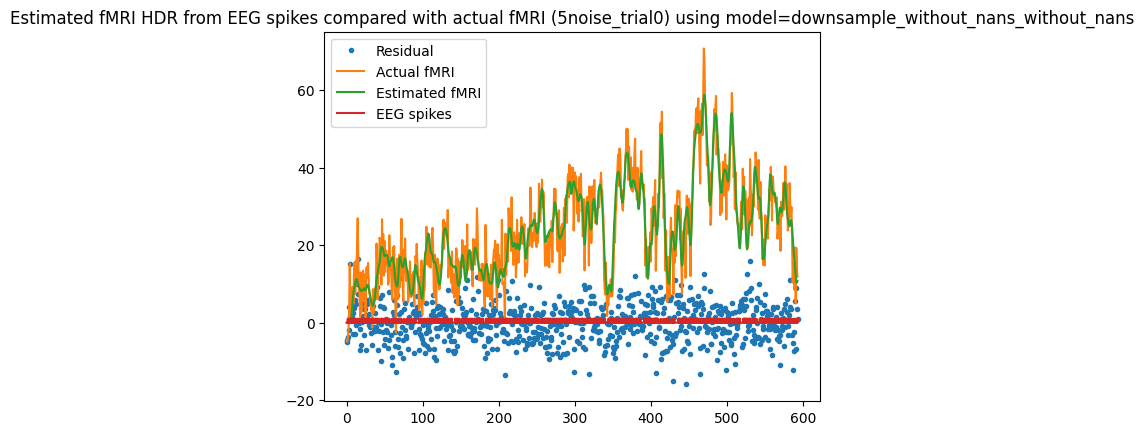

Residual Variance is 24.637050


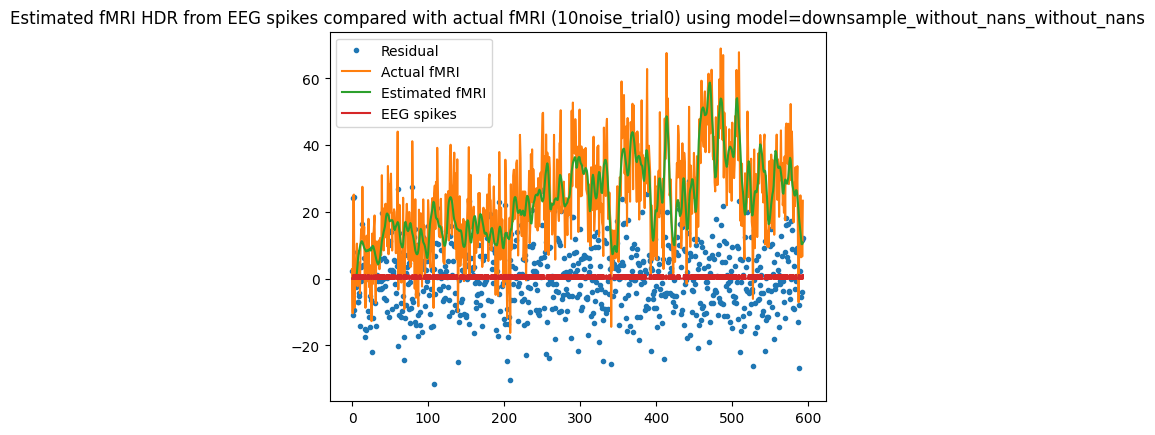

Residual Variance is 104.665351


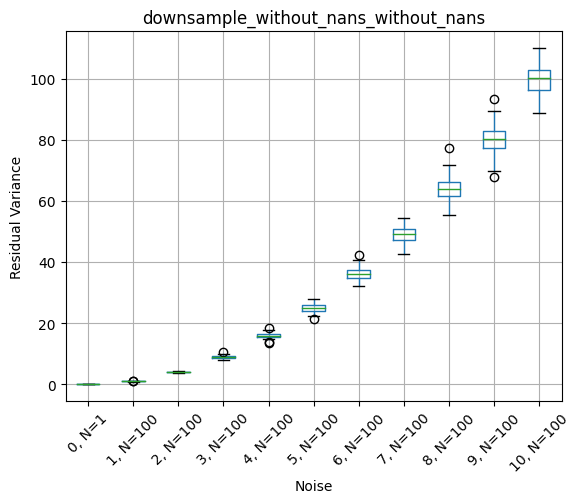

Scoring downsample_without_nans_with_nans delta=3, tau=1.75, alpha=2.25


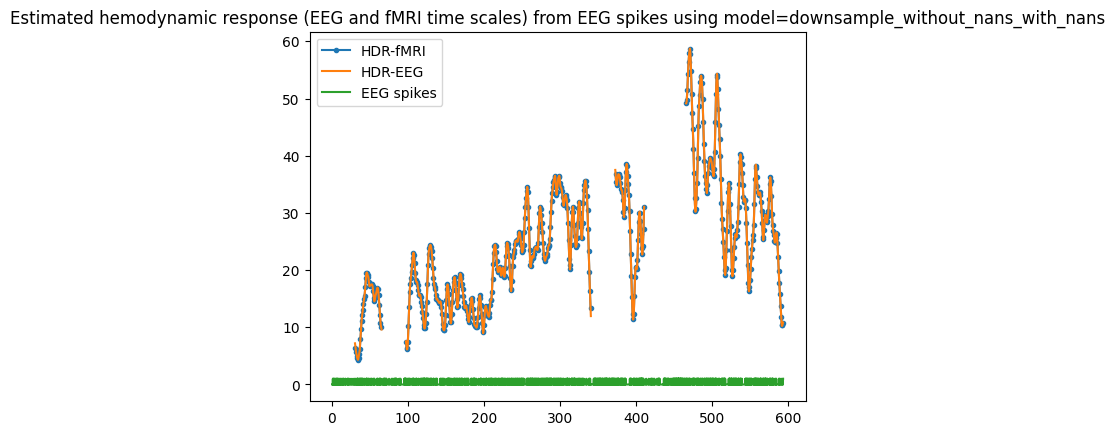

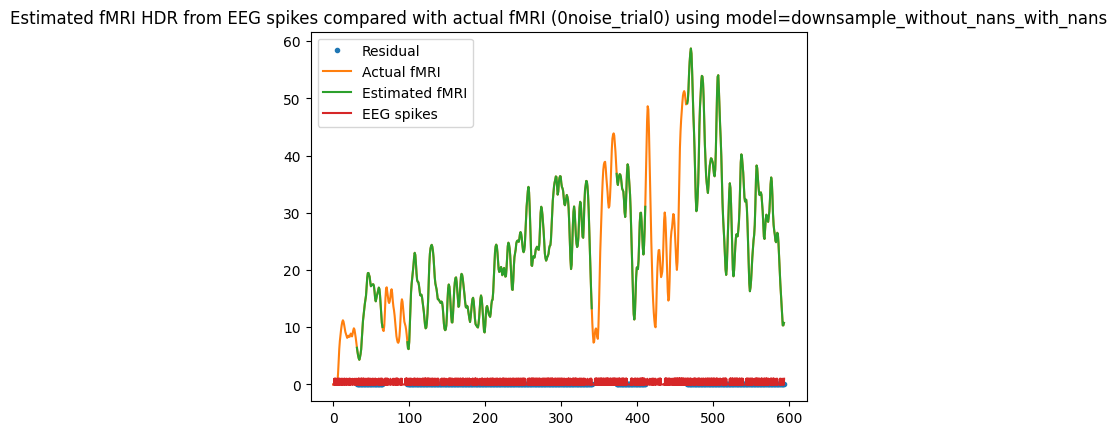

Residual Variance is 0.000000


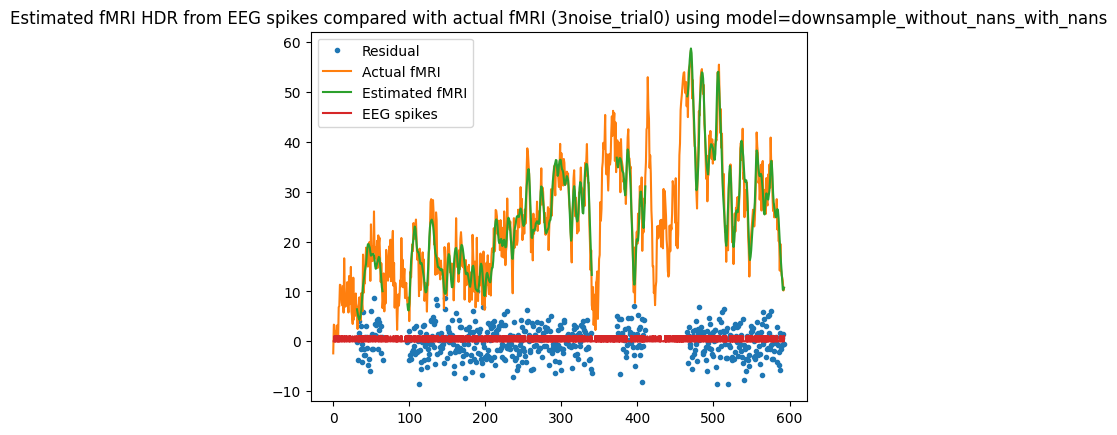

Residual Variance is 9.485892


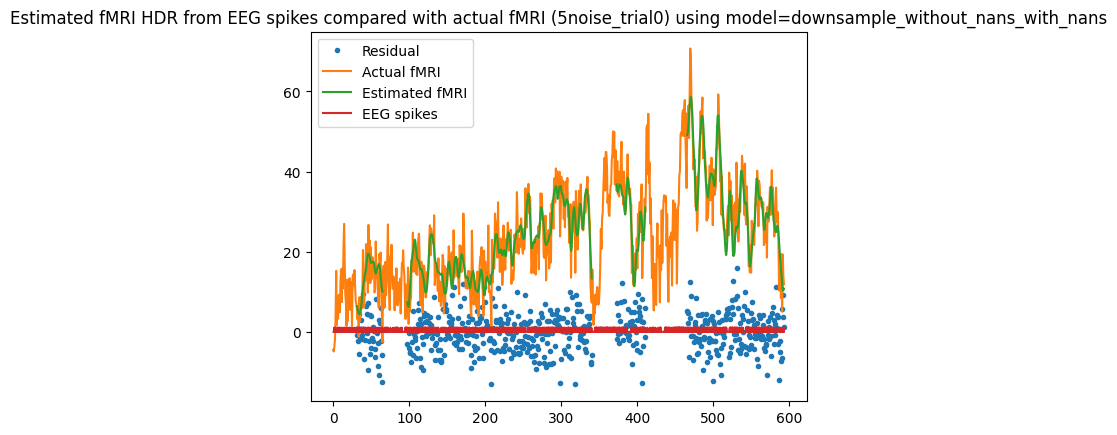

Residual Variance is 23.303622


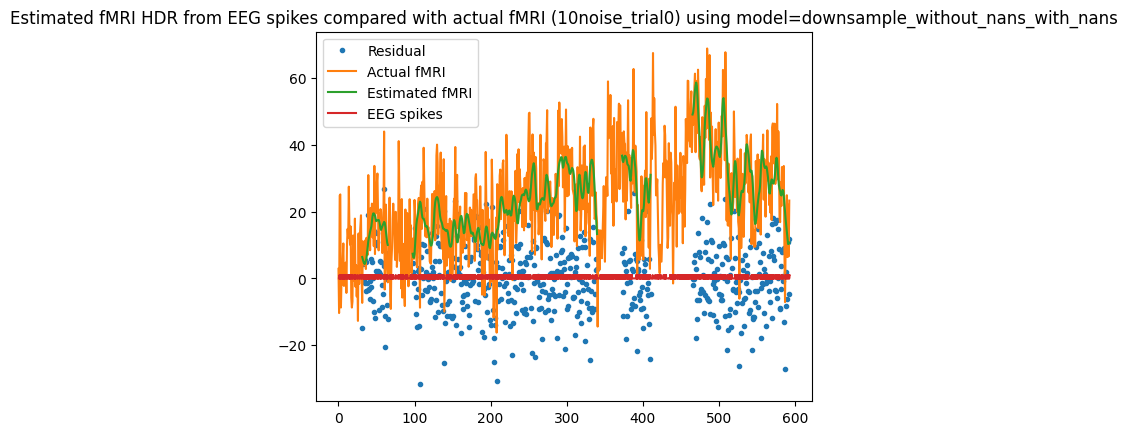

Residual Variance is 101.645735


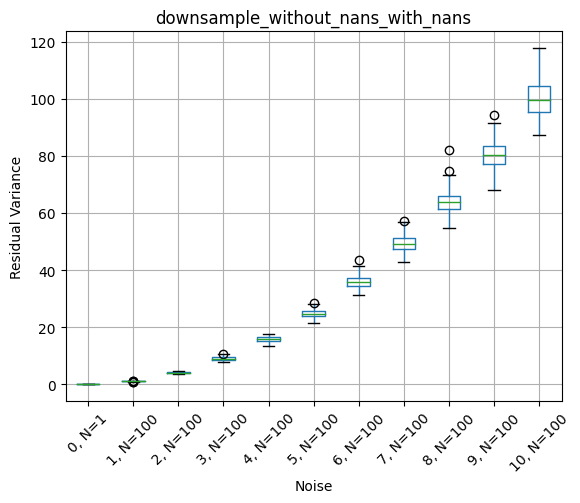

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name          0noise_trial0  \
0      downsample_without_nans_without_nans     101.54245091414316   
1         downsample_without_nans_with_nans       89.8835247290428   
2      downsample_without_nans_without_nans     100.90899742831454   
3         downsample_without_nans_with_nans       89.3789627082525   
4      downsample_without_nans_without_nans      100.2625829972493   
...                                     ...                    ...   
18937     downsample_without_nans_with_nans    0.11013277463951252   
18938  downsample_without_nans_without_nans   0.030328323365402726   
18939     downsample_without_nans_with_nans   0.027141858571476978   
18940  downsample_without_nans_without_nans   2.68401421387114e-28   
18941     downsample_without_nans_with_nans  2.560031951390018e-28   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0      102.83688287605288  104.18080984001307  106.93837826382442   
1       91.24922176269344   91.03370478307674   93.97224189433474   
2      102.20471839713416  103.52765372246849  106.34022455138891   
3       90.75517293743512   90.51927819801706   93.50700574433971   
4      101.55926973276846   102.8612401051997  105.72974308675383   
...                   ...                 ...                 ...   
18937  1.0667792499100812  3.5726623393374286   9.569697992441867   
18938  0.9800729172530631  3.6632874090359056    9.55912568088681   
18939  0.9770532918519187   3.531927899778883   9.501319687516633   
18940  0.9508170340060368  3.6875677557570232   9.544414437824683   
18941  0.9436977470108896  3.5444815758530197   9.485892455331726   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0      117.59724668884016  124.33860493724404  ...  102.23967307462533   
1       106.2635461176029   111.9407474733956  ...   89.68361253604981   
2       116.8801687121761   123.6829671652158  ...  101.61984432864477   
3      105.69393652588023  111.38054327886663  ...   89.19511725648653   
4      116.15047793357434  123.01489674965562  ...  100.98692783851865   
...                   ...                 ...  ...                 ...   
18937  15.705688580184807   23.41480902240587  ...  1.1559090675077135   
18938  15.700692810148741  24.670877224559938  ...  1.0861920177042508   
18939  15.704410642652045  23.331090562665263  ...  1.0644168178448539   
18940  15.722684597878017  24.637049880579433  ...  1.0463359139093027   
18941  15.756535998865015  23.303622154380513  ...  1.0282990300839714   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0      104.69413722765623    108.890175213576  116.88576097262414   
1       94.54414573268828    98.2582353113186  103.58592267469893   
2      104.09155205579601  108.23499012971426  116.21588829669878   
3       94.05238319114612   97.72680056968015   103.0404052858074   
4      103.47618898898033  107.56633674355366  115.53360138620502   
...                   ...                 ...                 ...   
18937   4.267081324918725   8.740934620222495  16.520195404898143   
18938   4.088852426628949   8.910080785631525   16.58152298058341   
18939   4.1

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 2.68401421387114e-28; at
       delta   tau  alpha
18940    3.0  1.75   2.25


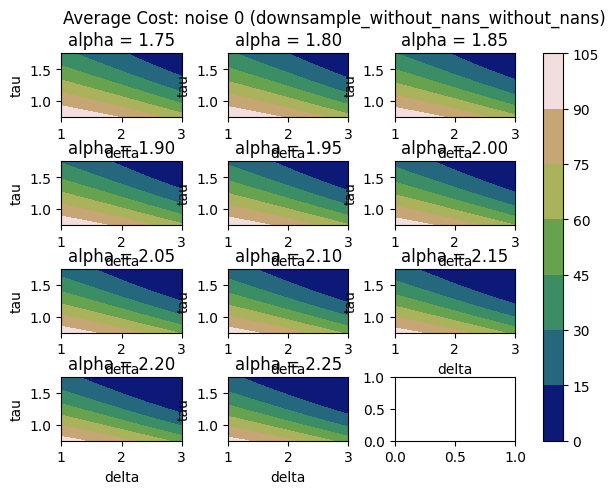

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                           1.015425e+02             
2                                           1.009090e+02             
4                                           1.002626e+02             
6                                           9.960317e+01             
8                                           9.893072e+01             
...                                                  ...             
18932                                       5.035122e-01             
18934                                       2.798210e-01             
18936                                       1.228428e-01             
18938                                       3.032832e-02             
18940                                       2.684014e-28             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 3, Tau target: 1.75, Alpha target: 2.25


delta   tau  alpha
0    3.0  1.75   2.25

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 3, Tau target: 1.75, Alpha target: 2.25


noise iteration          cost  delta   tau  alpha
0      0         0  2.684014e-28    3.0  1.75   2.25

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         1.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration          cost  delta   tau  alpha
0      0         0  2.684014e-28    3.0  1.75   2.25

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration          cost  delta   tau  alpha
0      0         0  2.684014e-28    3.0  1.75   2.25

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration          cost  delta   tau  alpha
0      0         0  2.684014e-28    3.0  1.75   2.25

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 2.560031951390018e-28; at
       delta   tau  alpha
18941    3.0  1.75   2.25


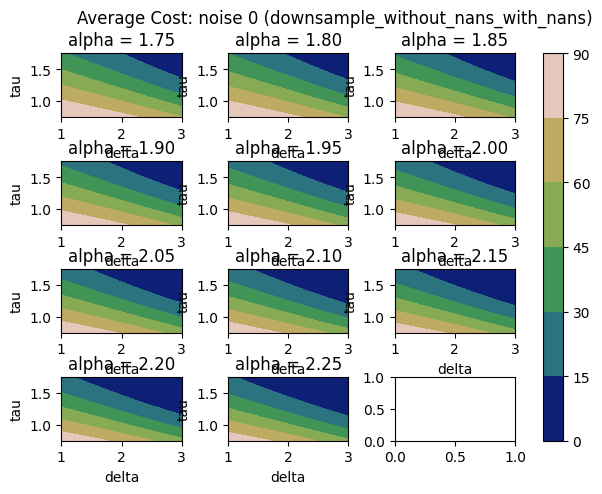

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                           8.988352e+01          
3                                           8.937896e+01          
5                                           8.886246e+01          
7                                           8.833389e+01          
9                                           8.779312e+01          
...                                                  ...          
18933                                       4.529879e-01          
18935                                       2.513097e-01          
18937                                       1.101328e-01          
18939                                       2.714186e-02          
18941                                       2.560032e-28          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 3, Tau target: 1.75, Alpha target: 2.25


delta   tau  alpha
0    3.0  1.75   2.25

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 3, Tau target: 1.75, Alpha target: 2.25


noise iteration          cost  delta   tau  alpha
0      0         0  2.560032e-28    3.0  1.75   2.25

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         1.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration          cost  delta   tau  alpha
0      0         0  2.560032e-28    3.0  1.75   2.25

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration          cost  delta   tau  alpha
0      0         0  2.560032e-28    3.0  1.75   2.25

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration          cost  delta   tau  alpha
0      0         0  2.560032e-28    3.0  1.75   2.25

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0016693749232122; at
       delta   tau  alpha
18940    3.0  1.75   2.25


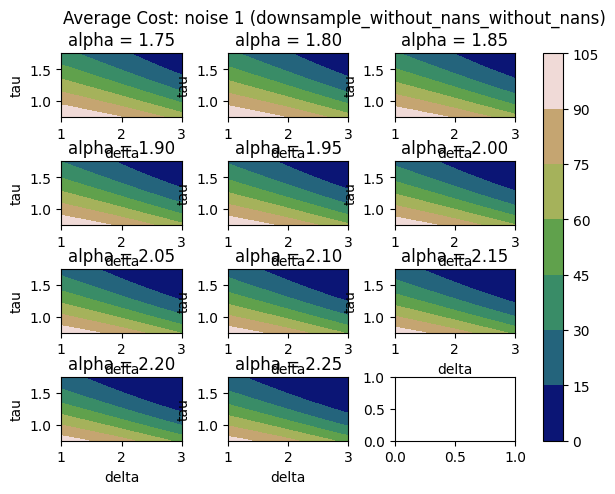

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.9876054718369573; at
       delta   tau  alpha
18940    3.0  1.75   2.25


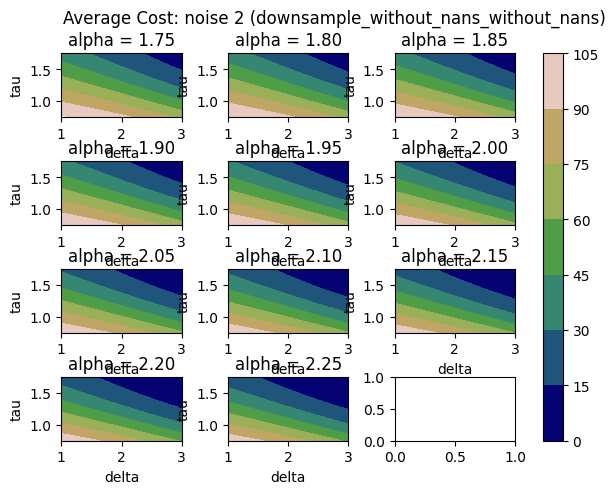

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.008964080587127; at
       delta   tau  alpha
18940    3.0  1.75   2.25


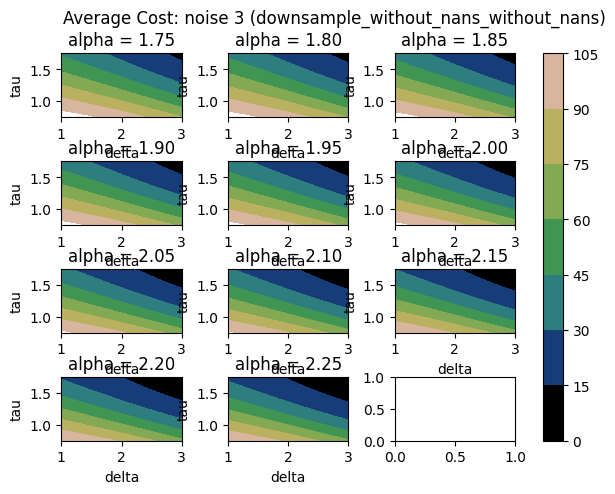

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.907726800734157; at
       delta   tau  alpha
18940    3.0  1.75   2.25


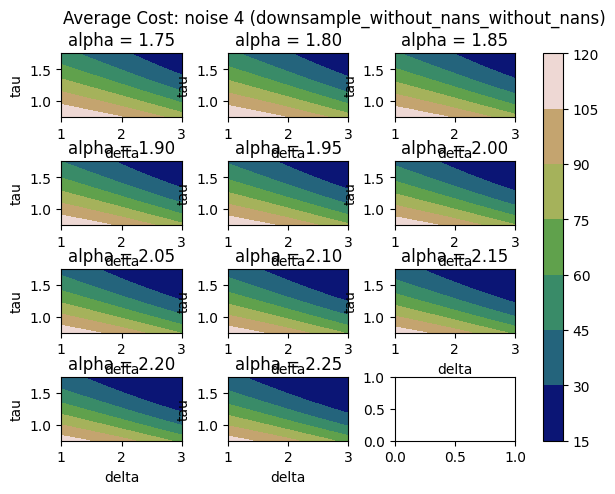

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.953945559922385; at
       delta   tau  alpha
18940    3.0  1.75   2.25


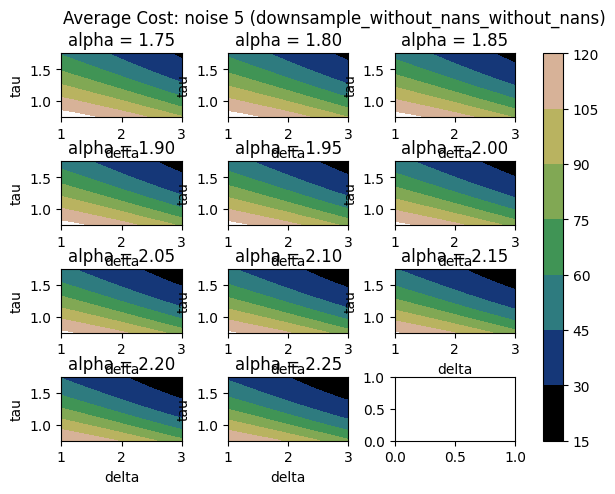

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.09352462127786; at
       delta   tau  alpha
18940    3.0  1.75   2.25


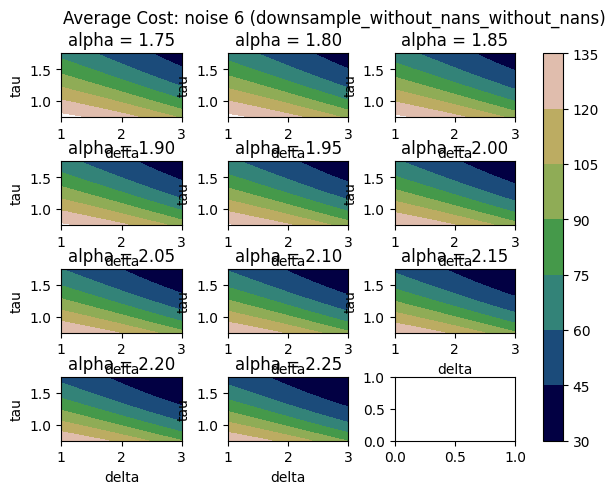

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.102394832636875; at
       delta   tau  alpha
18940    3.0  1.75   2.25


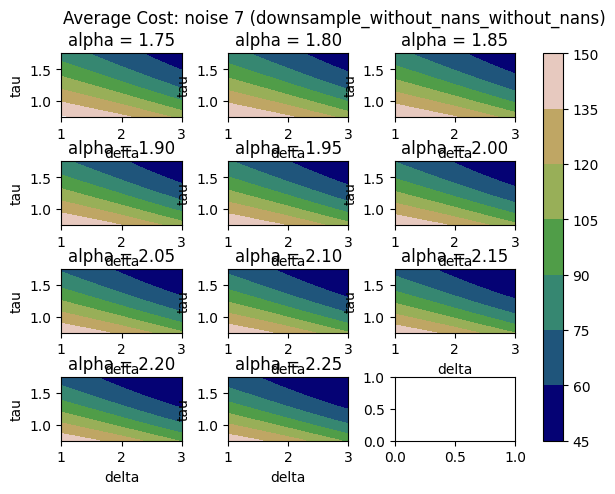

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.908156036356004; at
       delta   tau  alpha
18940    3.0  1.75   2.25


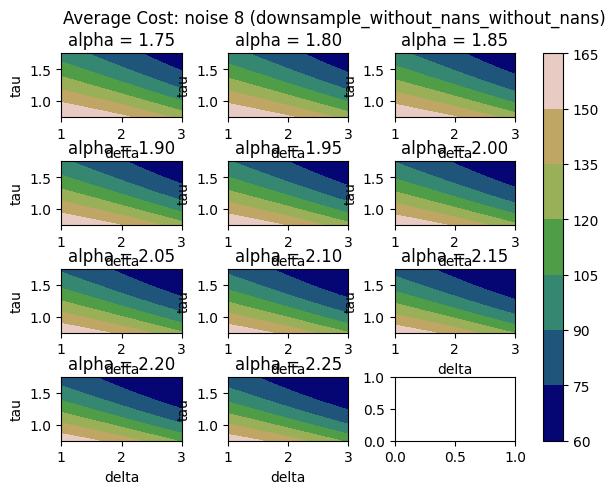

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.16320546594702; at
       delta   tau  alpha
18940    3.0  1.75   2.25


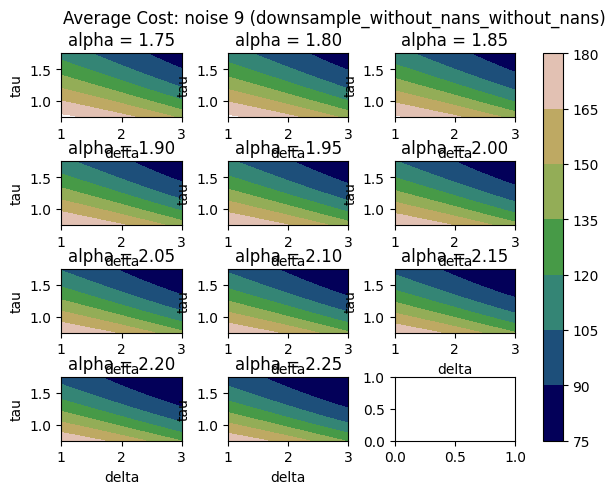

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.61362710513963; at
       delta   tau  alpha
18940    3.0  1.75   2.25


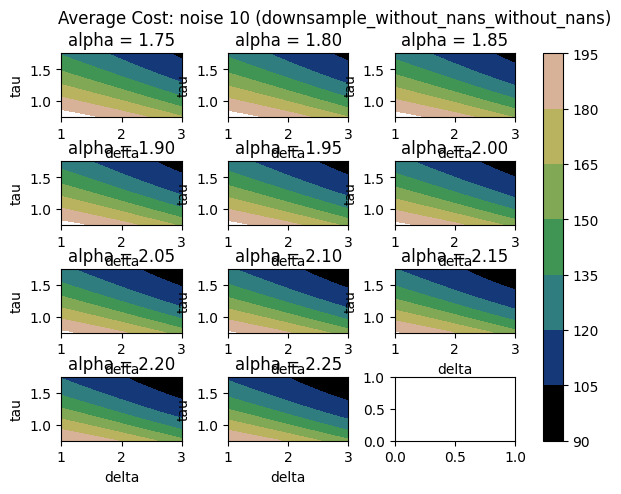

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

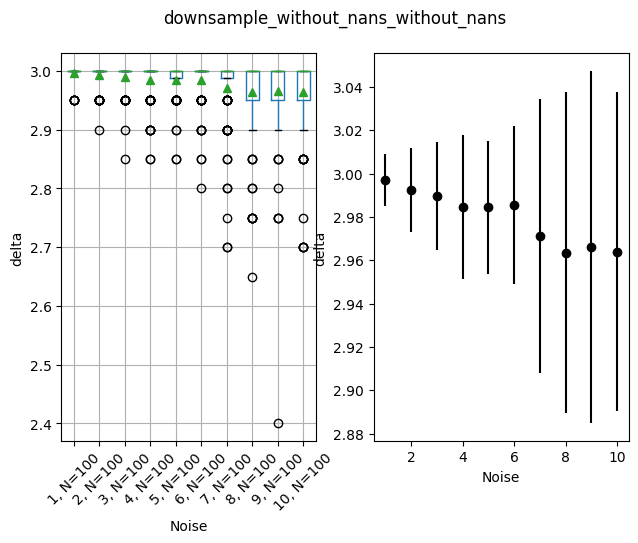

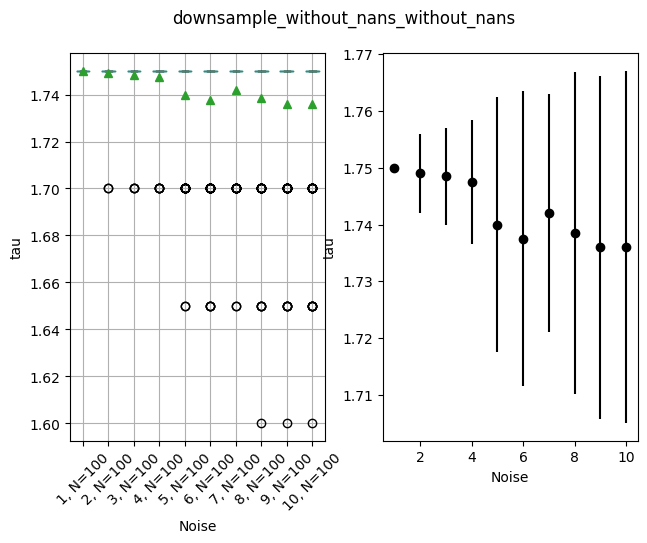

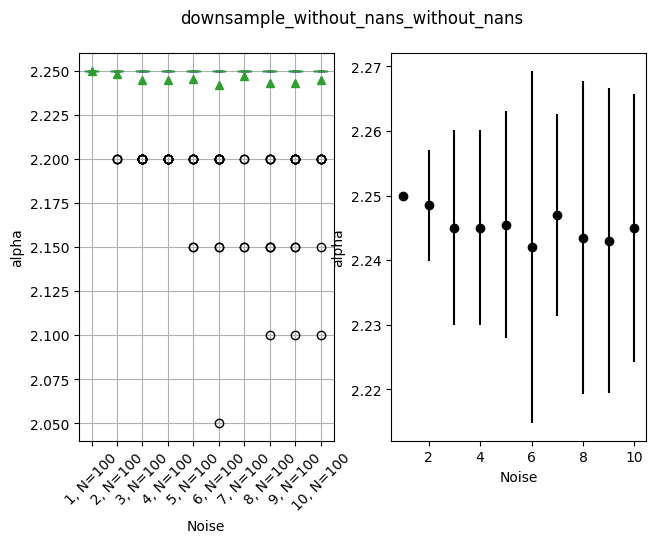

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9983930745121037; at
       delta   tau  alpha
18941    3.0  1.75   2.25


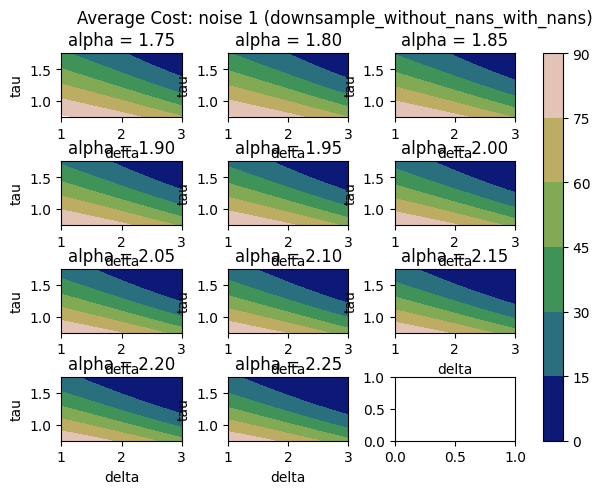

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 3.9984948340717295; at
       delta   tau  alpha
18941    3.0  1.75   2.25


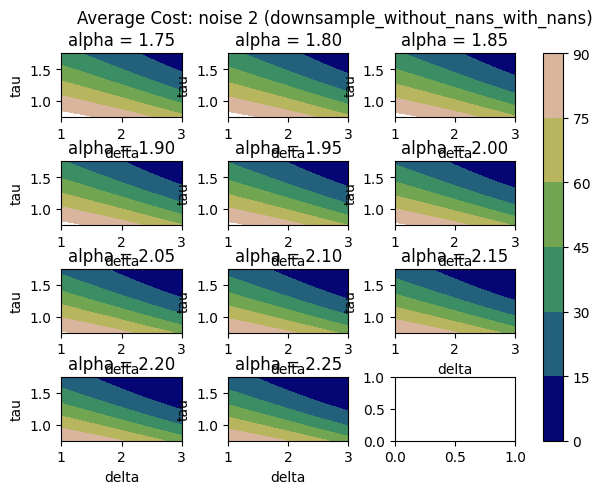

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.001809287311932; at
       delta   tau  alpha
18941    3.0  1.75   2.25


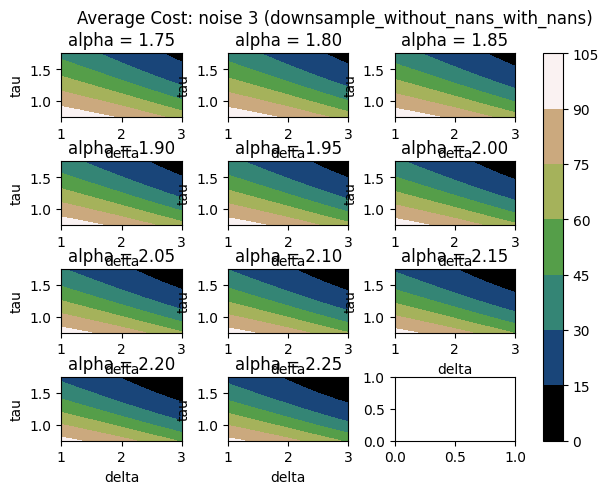

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.882223067135143; at
       delta   tau  alpha
18941    3.0  1.75   2.25


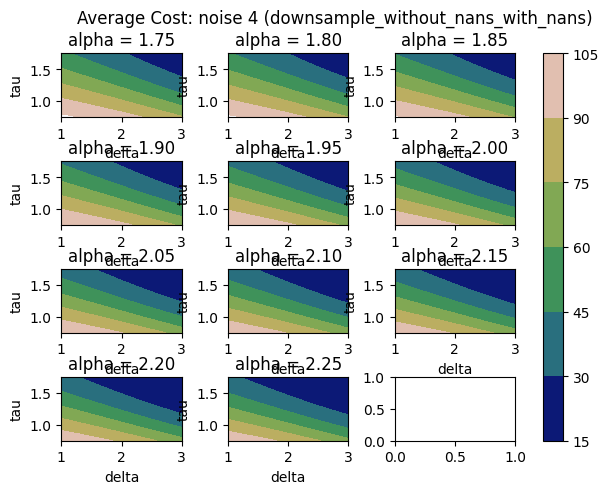

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.865297662361215; at
       delta   tau  alpha
18941    3.0  1.75   2.25


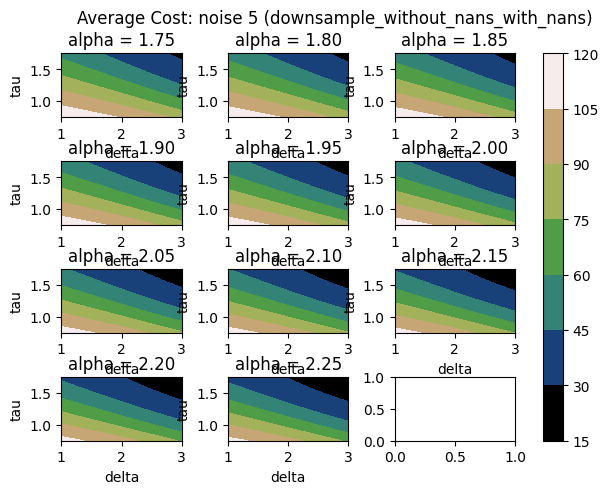

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.08802470025561; at
       delta   tau  alpha
18941    3.0  1.75   2.25


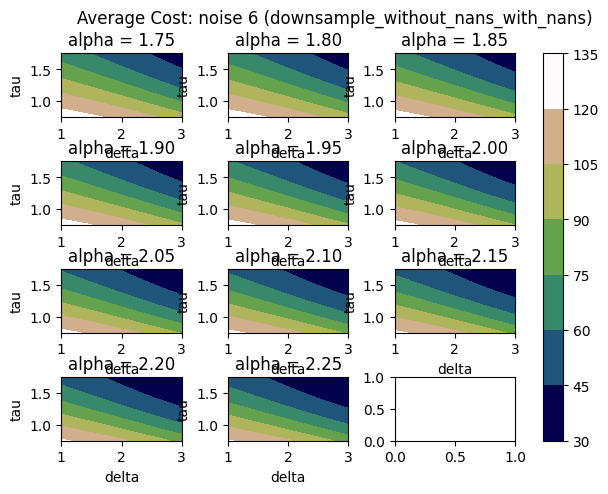

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.3246125519055; at
       delta   tau  alpha
18941    3.0  1.75   2.25


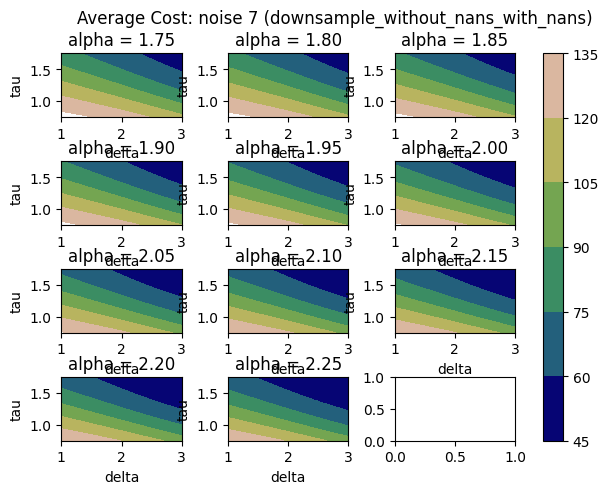

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.89218947408745; at
       delta   tau  alpha
18941    3.0  1.75   2.25


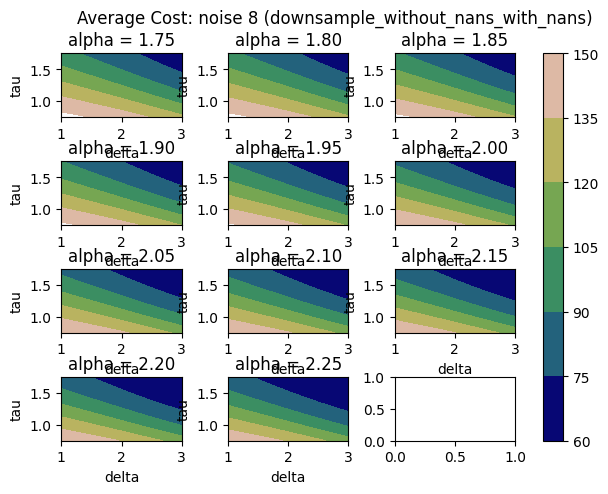

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.50962991920731; at
       delta   tau  alpha
18941    3.0  1.75   2.25


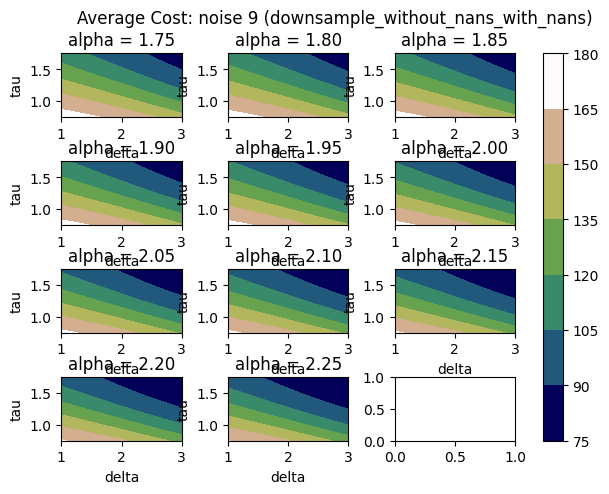

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.85148157687816; at
       delta   tau  alpha
18941    3.0  1.75   2.25


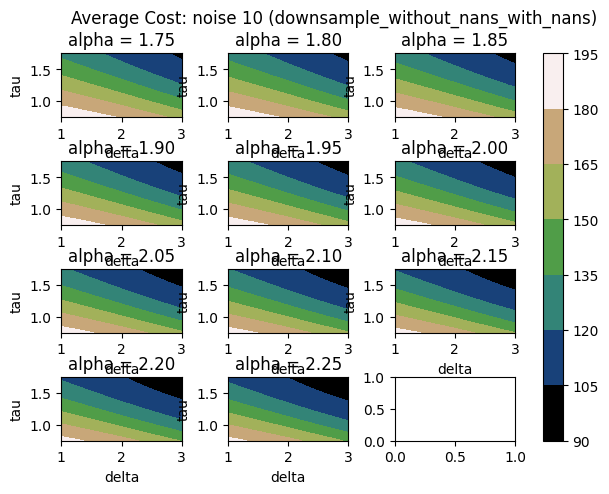

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


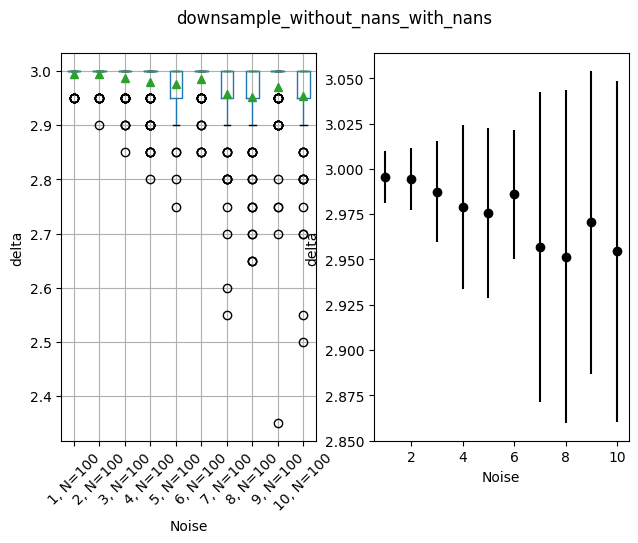

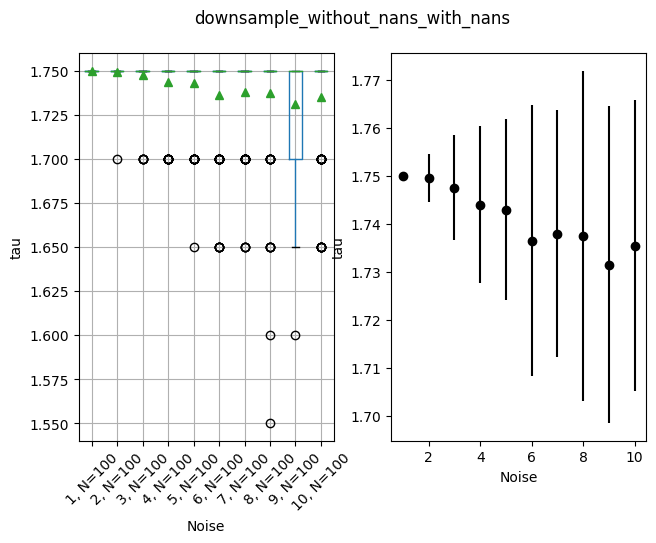

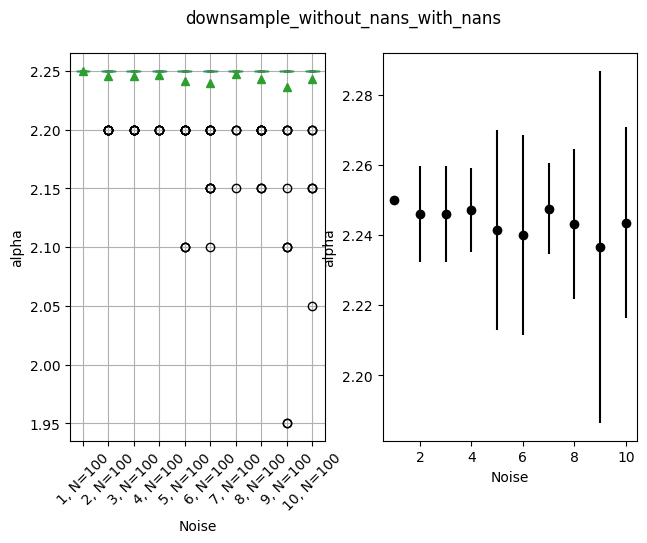

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         7    0.948578   2.950000000000002  1.7500000000000009   
1         1        34    1.055890   2.950000000000002  1.7500000000000009   
2         1        50    1.052538   2.950000000000002  1.7500000000000009   
3         1        54    0.941742   2.950000000000002  1.7500000000000009   
4         1        80    1.051707   2.950000000000002  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
1022     10        94   92.759467  3.0000000000000018  1.7500000000000009   
1023     10        95   97.830260  3.0000000000000018  1.7500000000000009   
1024     10        96  102.515767  3.0000000000000018  1.7500000000000009   
1025     10        98  106.791461  3.0000000000000018  1.7500000000000009   
1026     10        99   98.651034  3.0000000000000018  1.7500000000000009   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
1022  2.2500000000000004  
1023  2.2500000000000004  
1024  2.2500000000000004  
1025  2.2500000000000004  
1026  2.2500000000000004  

[1027 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
2                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
3                      100.0  1.01  0.100000  1.0  1.0  1.0  1.0  2.0
4                      100.0  1.01  0.100000  1.0  1.0  1.0  1.0  2.0
5                      100.0  1.07  0.256432  1.0  1.0  1.0  1.0  2.0
6                      100.0  1.02  0.140705  1.0  1.0  1.0  1.0  2.0
7                      100.0  1.03  0.171447  1.0  1.0  1.0  1.0  2.0
8                      100.0  1.05  0.219043  1.0  1.0  1.0  1.0  2.0
9                      100.0  1.04  0.196946  1.0  1.0  1.0  1.0  2.0
10                     100.0  1.04  0.196946  1.0  1.0  1.0  1.0  2.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
6         1         0    0.950817  3.0000000000000018  1.7500000000000009   
7         1         1    0.966353  3.0000000000000018  1.7500000000000009   
8         1         2    0.935025  3.0000000000000018  1.7500000000000009   
9         1         3    1.015380  3.0000000000000018  1.7500000000000009   
10        1         4    1.043598  3.0000000000000018  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
1022     10        94   92.759467  3.0000000000000018  1.7500000000000009   
1023     10        95   97.830260  3.0000000000000018  1.7500000000000009   
1024     10        96  102.515767  3.0000000000000018  1.7500000000000009   
1025     10        98  106.791461  3.0000000000000018  1.7500000000000009   
1026     10        99   98.651034  3.0000000000000018  1.7500000000000009   

                   alpha  
6     2.2500000000000004  
7     2.2500000000000004  
8     2.2500000000000004  
9     2.2500000000000004  
10    2.2500000000000004  
...                  ...  
1022  2.2500000000000004  
1023  2.2500000000000004  
1024  2.2500000000000004  
1025  2.2500000000000004  
1026  2.2500000000000004  

[812 rows x 6 columns]

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost               delta                 tau  \
0         1         7    0.948578   2.950000000000002  1.7500000000000009   
1         1        34    1.055890   2.950000000000002  1.7500000000000009   
2         1        50    1.052538   2.950000000000002  1.7500000000000009   
3         1        54    0.941742   2.950000000000002  1.7500000000000009   
4         1        80    1.051707   2.950000000000002  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
1022     10        94   92.759467  3.0000000000000018  1.7500000000000009   
1023     10        95   97.830260  3.0000000000000018  1.7500000000000009   
1024     10        96  102.515767  3.0000000000000018  1.7500000000000009   
1025     10        98  106.791461  3.0000000000000018  1.7500000000000009   
1026     10        99   98.651034  3.0000000000000018  1.7500000000000009   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
1022  2.2500000000000004  
1023  2.2500000000000004  
1024  2.2500000000000004  
1025  2.2500000000000004  
1026  2.2500000000000004  

[900 rows x 6 columns]

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

Empty DataFrame
Columns: [(delta, count), (delta, unique), (delta, top), (delta, freq), (tau, count), (tau, unique), (tau, top), (tau, freq)]
Index: []

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1         7    0.948578   2.950000000000002  1.7500000000000009   
1         1        34    1.055890   2.950000000000002  1.7500000000000009   
2         1        50    1.052538   2.950000000000002  1.7500000000000009   
3         1        54    0.941742   2.950000000000002  1.7500000000000009   
4         1        80    1.051707   2.950000000000002  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
1022     10        94   92.759467  3.0000000000000018  1.7500000000000009   
1023     10        95   97.830260  3.0000000000000018  1.7500000000000009   
1024     10        96  102.515767  3.0000000000000018  1.7500000000000009   
1025     10        98  106.791461  3.0000000000000018  1.7500000000000009   
1026     10        99   98.651034  3.0000000000000018  1.7500000000000009   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
1022  2.2500000000000004  
1023  2.2500000000000004  
1024  2.2500000000000004  
1025  2.2500000000000004  
1026  2.2500000000000004  

[934 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1       100      2  3.0000000000000018   94   100      1  1.7500000000000009   
10       93      6  3.0000000000000018   66    93      4  1.7500000000000009   
2        97      3  3.0000000000000018   83    97      2  1.7500000000000009   
3        90      4  3.0000000000000018   72    90      2  1.7500000000000009   
4        91      4  3.0000000000000018   68    91      2  1.7500000000000009   
5        94      4  3.0000000000000018   70    94      3  1.7500000000000009   
6        89      5  3.0000000000000018   73    89      3  1.7500000000000009   
7        97      7  3.0000000000000018   72    97      3  1.7500000000000009   
8        93      7  3.0000000000000018   67    93      4  1.7500000000000009   
9        90      7  3.0000000000000018   67    90      4  1.7500000000000009   

            
      freq  
noise       
1      100  
10      77  
2       95  
3       87  
4       86  
5       76  
6       68  
7       82  
8       76  
9       70

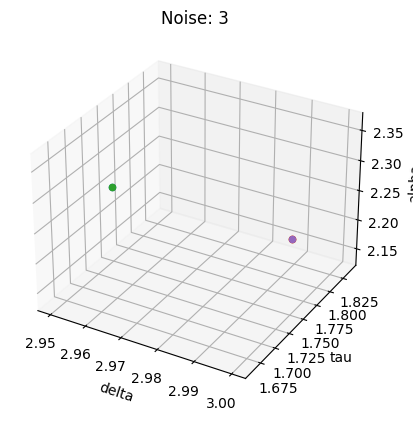

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

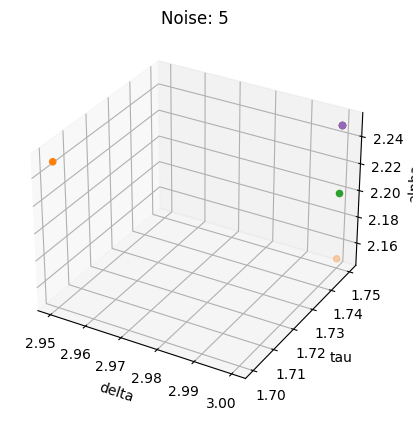

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

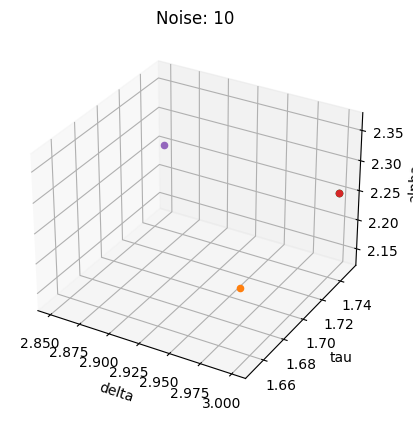

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         7    0.940753   2.950000000000002  1.7500000000000009   
1         1        18    1.038129   2.950000000000002  1.7500000000000009   
2         1        24    0.933095   2.950000000000002  1.7500000000000009   
3         1        26    1.003204   2.950000000000002  1.7500000000000009   
4         1        34    1.004452   2.950000000000002  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
1024     10        94   95.341659  3.0000000000000018  1.7500000000000009   
1025     10        95   99.227831  3.0000000000000018  1.7500000000000009   
1026     10        96  101.826626  3.0000000000000018  1.7500000000000009   
1027     10        98  108.338869  3.0000000000000018  1.7500000000000009   
1028     10        99   98.612092  3.0000000000000018  1.7500000000000009   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
1024  2.2500000000000004  
1025  2.2500000000000004  
1026  2.2500000000000004  
1027  2.2500000000000004  
1028  2.2500000000000004  

[1029 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
2                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
3                      100.0  1.01  0.100000  1.0  1.0  1.0  1.0  2.0
4                      100.0  1.04  0.196946  1.0  1.0  1.0  1.0  2.0
5                      100.0  1.06  0.238683  1.0  1.0  1.0  1.0  2.0
6                      100.0  1.04  0.196946  1.0  1.0  1.0  1.0  2.0
7                      100.0  1.02  0.140705  1.0  1.0  1.0  1.0  2.0
8                      100.0  1.02  0.140705  1.0  1.0  1.0  1.0  2.0
9                      100.0  1.06  0.238683  1.0  1.0  1.0  1.0  2.0
10                     100.0  1.04  0.196946  1.0  1.0  1.0  1.0  2.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
9         1         0    0.943698  3.0000000000000018  1.7500000000000009   
10        1         1    0.971174  3.0000000000000018  1.7500000000000009   
11        1         2    0.920342  3.0000000000000018  1.7500000000000009   
12        1         3    1.011698  3.0000000000000018  1.7500000000000009   
13        1         4    1.040958  3.0000000000000018  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
1024     10        94   95.341659  3.0000000000000018  1.7500000000000009   
1025     10        95   99.227831  3.0000000000000018  1.7500000000000009   
1026     10        96  101.826626  3.0000000000000018  1.7500000000000009   
1027     10        98  108.338869  3.0000000000000018  1.7500000000000009   
1028     10        99   98.612092  3.0000000000000018  1.7500000000000009   

                   alpha  
9     2.2500000000000004  
10    2.2500000000000004  
11    2.2500000000000004  
12    2.2500000000000004  
13    2.2500000000000004  
...                  ...  
1024  2.2500000000000004  
1025  2.2500000000000004  
1026  2.2500000000000004  
1027  2.2500000000000004  
1028  2.2500000000000004  

[800 rows x 6 columns]

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost               delta                 tau  \
0         1         7    0.940753   2.950000000000002  1.7500000000000009   
1         1        18    1.038129   2.950000000000002  1.7500000000000009   
2         1        24    0.933095   2.950000000000002  1.7500000000000009   
3         1        26    1.003204   2.950000000000002  1.7500000000000009   
4         1        34    1.004452   2.950000000000002  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
1024     10        94   95.341659  3.0000000000000018  1.7500000000000009   
1025     10        95   99.227831  3.0000000000000018  1.7500000000000009   
1026     10        96  101.826626  3.0000000000000018  1.7500000000000009   
1027     10        98  108.338869  3.0000000000000018  1.7500000000000009   
1028     10        99   98.612092  3.0000000000000018  1.7500000000000009   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
1024  2.2500000000000004  
1025  2.2500000000000004  
1026  2.2500000000000004  
1027  2.2500000000000004  
1028  2.2500000000000004  

[882 rows x 6 columns]

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

Empty DataFrame
Columns: [(delta, count), (delta, unique), (delta, top), (delta, freq), (tau, count), (tau, unique), (tau, top), (tau, freq)]
Index: []

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1         7    0.940753   2.950000000000002  1.7500000000000009   
1         1        18    1.038129   2.950000000000002  1.7500000000000009   
2         1        24    0.933095   2.950000000000002  1.7500000000000009   
3         1        26    1.003204   2.950000000000002  1.7500000000000009   
4         1        34    1.004452   2.950000000000002  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
1024     10        94   95.341659  3.0000000000000018  1.7500000000000009   
1025     10        95   99.227831  3.0000000000000018  1.7500000000000009   
1026     10        96  101.826626  3.0000000000000018  1.7500000000000009   
1027     10        98  108.338869  3.0000000000000018  1.7500000000000009   
1028     10        99   98.612092  3.0000000000000018  1.7500000000000009   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
1024  2.2500000000000004  
1025  2.2500000000000004  
1026  2.2500000000000004  
1027  2.2500000000000004  
1028  2.2500000000000004  

[929 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1       100      2  3.0000000000000018   91   100      1  1.7500000000000009   
10       94      9  3.0000000000000018   66    94      3  1.7500000000000009   
2        92      3  3.0000000000000018   82    92      2  1.7500000000000009   
3        92      4  3.0000000000000018   74    92      2  1.7500000000000009   
4        94      5  3.0000000000000018   72    94      2  1.7500000000000009   
5        89      6  3.0000000000000018   62    89      3  1.7500000000000009   
6        90      4  3.0000000000000018   72    90      3  1.7500000000000009   
7        97      9  3.0000000000000018   66    97      3  1.7500000000000009   
8        91      8  3.0000000000000018   64    91      5  1.7500000000000009   
9        90      7  3.0000000000000018   68    90      4  1.7500000000000009   

            
      freq  
noise       
1      100  
10      74  
2       91  
3       87  
4       82  
5       79  
6       67  
7       77  
8       76  
9       65

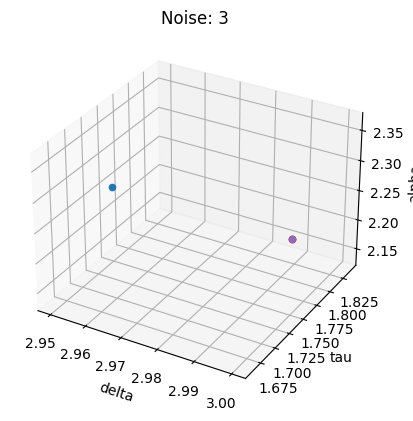

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

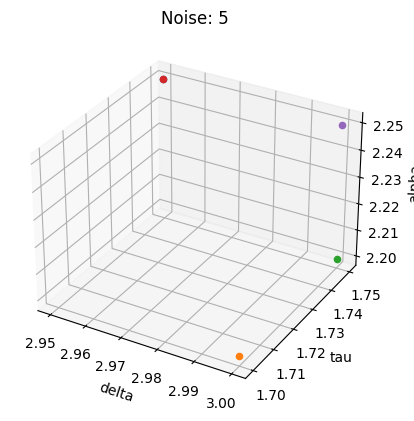

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

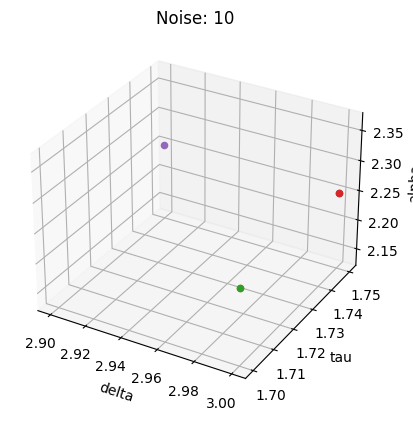

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

In [67]:
descriptions[0]

0noise_trial0       1noise_trial0       2noise_trial0  \
count              9471.0              9471.0              9471.0   
mean            40.389497           41.446518           42.596945   
std             25.231965           25.324215           25.052858   
min                   0.0            0.950817            3.657336   
25%             19.214691            20.20717           21.517048   
50%             36.861362           37.905661           38.825599   
75%             59.840624           60.941794           61.761059   
max            101.542451          102.836883           104.18081   
delta  3.0000000000000018  3.0000000000000018  2.9000000000000017   
tau    1.7500000000000009  1.7500000000000009  1.7500000000000009   
alpha  2.2500000000000004  2.2500000000000004  2.2500000000000004   

            3noise_trial0       4noise_trial0       5noise_trial0  \
count              9471.0              9471.0              9471.0   
mean            48.249754            54.30832           63.962099   
std             24.392912           25.114579           24.696064   
min              9.541501           15.659694            24.63705   
25%             27.748586           33.149295           43.163472   
50%             44.802344           50.420093           60.467637   
75%             67.082203           73.352501           83.121159   
max            106.938378          117.597247          124.338605   
delta   2.950000000000002  2.9000000000000017  3.0000000000000018   
tau    1.7500000000000009  1.7500000000000009  1.7500000000000009   
alpha  2.2500000000000004  2.2500000000000004  2.2500000000000004   

            6noise_trial0       7noise_trial0       8noise_trial0  \
count              9471.0              9471.0              9471.0   
mean            73.528345           83.658122          108.799472   
std             24.406563           25.539322           25.501629   
min             35.266707           45.877181           66.079538   
25%             53.006911           62.131044           87.505811   
50%             69.978968            79.38463          105.688888   
75%             92.207858          102.647781          128.760259   
max             134.47038          149.882707          169.584632   
delta   2.950000000000002  2.8000000000000016  3.0000000000000018   
tau    1.7500000000000009  1.7500000000000009  1.7500000000000009   
alpha  2.2500000000000004  2.2500000000000004  2.2500000000000004   

            9noise_trial0  ...      1noise_trial99      2noise_trial99  \
count              9471.0  ...              9471.0              9471.0   
mean           112.977998  ...           41.593888           44.795986   
std             24.734668  ...           25.160436            25.03949   
min             72.001251  ...            1.046336            4.027721   
25%             92.284253  ...           20.495313           23.830019   
50%            109.868982  ...           38.141517           41.438277   
75%            132.080188  ...           61.035063           64.213758   
max            172.747724  ...          102.239673          104.694137   
delta  3.0000000000000018  ...  3.0000000000000018  3.0000000000000018   
tau    1.7500000000000009  ...  1.7500000000000009  1.7500000000000009   
alpha  2.2500000000000004  ...  2.2500000000000004  2.2500000000000004   

           3noise_trial99      4noise_trial99      5noise_trial99  \
count              9471.0              9471.0              9471.0   
mean            47.942827           55.334824            67.06613   
std             24.637624           24.875622            24.53332   
min              8.860023           16.564123           27.358227   
25%             27.262843           34.427622           46.509153   
50%             44.347456           51.567275           63.866767   
75%             66.730187            74.33388           86.141819   
max            108.890175          116.885761          125.915316   
delta   2.95000

In [68]:
descriptions[1]

0noise_trial0       1noise_trial0       2noise_trial0  \
count              9471.0              9471.0              9471.0   
mean            36.648432           37.999979            38.27594   
std             22.628678            22.76878            22.05465   
min                   0.0            0.943698            3.521251   
25%             17.641048            18.90746           19.681135   
50%             33.754195           35.121971           35.196873   
75%             54.331526           55.813127           55.380341   
max             89.883525           91.249222           91.033705   
delta  3.0000000000000018  3.0000000000000018   2.950000000000002   
tau    1.7500000000000009  1.7500000000000009  1.7500000000000009   
alpha  2.2500000000000004  2.2500000000000004  2.2500000000000004   

            3noise_trial0       4noise_trial0       5noise_trial0  \
count              9471.0              9471.0              9471.0   
mean            43.899429           50.558021           58.653379   
std             21.421551           22.687371           22.187847   
min              9.485672           15.674175           23.301543   
25%             25.854299           31.413094           39.855556   
50%             41.071319           47.205984           55.615418   
75%             60.660889           67.950773           76.137085   
max             93.972242          106.263546          111.940747   
delta   2.950000000000002  2.8500000000000014   2.950000000000002   
tau    1.7500000000000009  1.7500000000000009  1.7500000000000009   
alpha  2.2500000000000004  2.2500000000000004  2.2500000000000004   

            6noise_trial0       7noise_trial0       8noise_trial0  \
count              9471.0              9471.0              9471.0   
mean             67.52305           76.093086          104.689336   
std              21.23042           22.034982           22.173566   
min             34.258433            43.69185           66.192715   
25%             49.576391            57.41985           86.132931   
50%             64.544781           72.566193          102.412075   
75%             84.017169           92.637283          122.449738   
max            119.057258          131.995797          154.647478   
delta   2.950000000000002  2.7500000000000018  3.0000000000000018   
tau    1.7500000000000009  1.7500000000000009  1.7500000000000009   
alpha  2.2500000000000004  2.2500000000000004  2.2500000000000004   

            9noise_trial0  ...      1noise_trial99      2noise_trial99  \
count              9471.0  ...              9471.0              9471.0   
mean           106.658351  ...           37.465257           41.396207   
std             21.596215  ...           22.315516           22.785787   
min             71.566894  ...            1.028299            4.126318   
25%             88.584912  ...           18.748609           22.285897   
50%            103.944689  ...           34.647489           38.531097   
75%             123.26215  ...           54.948714           59.249182   
max             158.97409  ...           89.683613           94.544146   
delta  3.0000000000000018  ...  3.0000000000000018  3.0000000000000018   
tau    1.7500000000000009  ...  1.7500000000000009  1.7500000000000009   
alpha  2.2500000000000004  ...  2.2500000000000004  2.2500000000000004   

           3noise_trial99      4noise_trial99      5noise_trial99  \
count              9471.0              9471.0              9471.0   
mean            44.291613           50.638594           62.811178   
std              22.39586           21.822275           21.562655   
min              8.629316           16.443614           26.727797   
25%             25.440876           32.219042            44.77296   
50%             41.209901           47.484072             60.3643   
75%             61.616158           67.505859           79.835521   
max             98.258235          103.585923          112.573699   
delta   2.95000

In [69]:
len(descriptions)

2